In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
import os

In [73]:
Data = os.path.join(os.path.expanduser("~"), "Desktop", "Credit_data.csv")
data = pd.read_csv(Data)

data.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


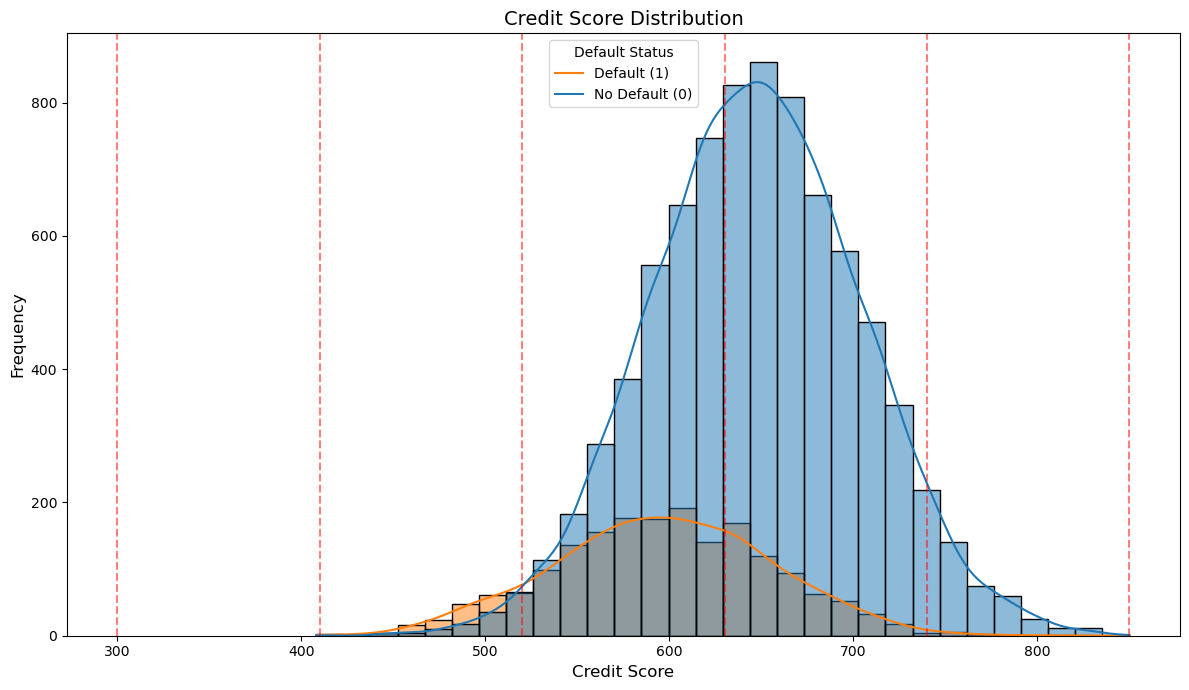

In [74]:
plt.figure(figsize=(12, 7))

# Plot a histogram with kernel density estimate
sns.histplot(data=data, x='fico_score',hue = 'default', kde=True, bins=30)

# Add vertical lines for possible bin boundaries
# Equal-width example: 5 bins
bin_edges = np.linspace(300, 850, 6)
for edge in bin_edges:
    plt.axvline(x=edge, color='r', linestyle='--', alpha=0.5)

# Add labels and title
plt.xlabel('Credit Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Credit Score Distribution', fontsize=14)

# Add a legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='r', linestyle='--', lw=2)]
plt.legend(custom_lines, ['Equal-Width Bin Boundaries'], loc='upper right')
plt.legend(['Default (1)', 'No Default (0)'], title='Default Status')
# Show the plot
plt.tight_layout()
plt.show()

Bucket 1: 0.7209
bucket_Bucket 2: 0.3927
bucket_Bucket 3: 0.1668
bucket_Bucket 4: 0.0665
bucket_Bucket 5: 0.0216


/Users/sidkondubhatla/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


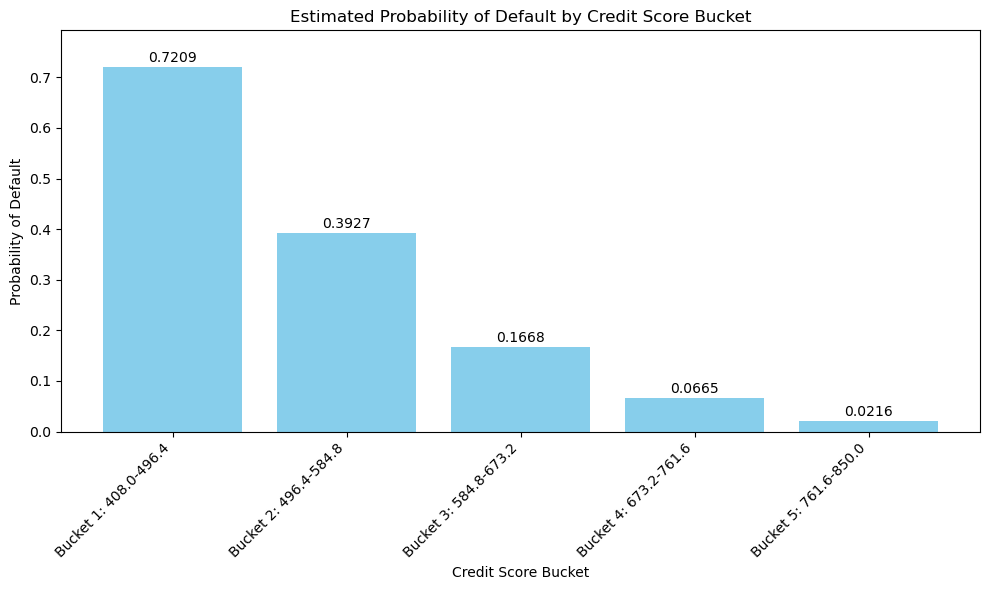


Observed default rates:
Bucket 1: 408.0-496.4    0.720930
Bucket 2: 496.4-584.8    0.392736
Bucket 3: 584.8-673.2    0.166792
Bucket 4: 673.2-761.6    0.066461
Bucket 5: 761.6-850.0    0.021622
Name: default, dtype: float64


In [ ]:

bins = [300, 550, 620, 680, 740, 850] 
    
 # Assign each score to a bucket
labels = [f'Bucket {i+1}' for i in range(len(bins)-1)]
binned_data = pd.cut(data['fico_score'], bins=bins, labels=labels, include_lowest=True)
    


# Apply bucketing
df, bins, labels = create_buckets(data, method='equal_width', num_buckets=5)

# Create dummy variables for the buckets
encoder = OneHotEncoder(sparse=False, drop='first')
bucket_dummies = encoder.fit_transform(data[['bucket']])
bucket_df = pd.DataFrame(bucket_dummies, columns=encoder.get_feature_names_out(['bucket']))

# Combine with original dataframe
model_df = pd.concat([data[['default']], bucket_df], axis=1)

# Fit logistic regression model
X = model_df.drop('default', axis=1)
y = model_df['default']
X = sm.add_constant(X)  # Add intercept
model = sm.Logit(y, X).fit(disp=0)  # disp=0 suppresses convergence messages

# Calculate and print probabilities for each bucket
pd_by_bucket = {}
pd_by_bucket['Bucket 1'] = model.params['const']  # Base bucket (dropped in one-hot encoding)

for bucket in X.columns[1:]:
    pd_by_bucket[bucket] = 1/(1 + np.exp(-(model.params['const'] + model.params[bucket])))

# Add base bucket
pd_by_bucket['Bucket 1'] = 1/(1 + np.exp(-model.params['const']))

# Print results
for bucket, pd in pd_by_bucket.items():
    print(f"{bucket}: {pd:.4f}")
bucket_labels = []
for i in range(len(bins)-1):
    bucket_labels.append(f'Bucket {i+1}: {bins[i]}-{bins[i+1]}')
# Plot the results
plt.figure(figsize=(10, 6))
pds = list(pd_by_bucket.values())
plt.bar(bucket_labels, pds, color='skyblue')
plt.xlabel('Credit Score Bucket')
plt.ylabel('Probability of Default')
plt.title('Estimated Probability of Default by Credit Score Bucket')
plt.ylim(0, max(pds) * 1.1)  # Add some space above the highest bar

# Add text labels on top of the bars
for i, v in enumerate(pds):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# For the observed default rates comparison, you can also use these more descriptive labels
observed_pd = df.groupby('bucket')['default'].mean()
observed_pd.index = bucket_labels
print("\nObserved default rates:")
print(observed_pd)